# Assignment 3 - Supervised Learning: model training and evaluation

## *Maobin Guo*
Netid: mg471

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), which is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Develop an understanding the optimal minimum misclassification error classifier (Bayes' classifier)

# 1
## [50 points] Classification using logistic regression: build it from the ground up

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences, etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

**(a)** 

In [1]:
import pandas as pd

TRAIN_PERCENT = 0.7

df = pd.read_csv("./data/A3_Q1_data.csv")

train_size = int(df.shape[0] * TRAIN_PERCENT)

X_train = df.iloc[:train_size, :][["x1", "x2"]]
X_test  = df.iloc[train_size:, :][["x1", "x2"]]
Y_train = df.iloc[:train_size, :]["y"]
Y_test  = df.iloc[train_size:, :]["y"]

Text(0.5, 1.0, 'Scatter plot of training data')

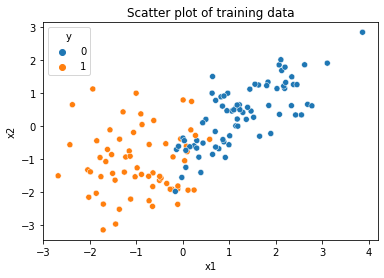

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=X_train, x="x1", y="x2", hue=Y_train)
plt.title("Scatter plot of training data")

Although there some different types of points mixed, the data appears separable. The logistic regression is a reasonable choice for this dataset because the decision boundary is clear and linear. 

**(b)**

In [3]:
print("The missing value of the dataset: \r\n{}".format(df.isnull().any()))

df.describe()

The missing value of the dataset: 
x1    False
x2    False
y     False
dtype: bool


,x1,x2,y
count,200.000000,200.000000,200.000000
mean,0.151376,-0.385426,0.485000
std,1.411722,1.217490,0.501029
min,-3.210005,-3.193456,0.000000
25%,-0.912029,-1.341047,0.000000
50%,0.112286,-0.479684,0.000000
75%,1.174400,0.495114,1.000000
max,3.867647,3.103541,1.000000


1. There is no missing value in this dataset. 
2. The features' value ranges are almost the same; hence, there is no need to scale them.

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a single training data pair $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the entire training dataset $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**(c)**

$
\begin{aligned}
L(W) &= \prod_{i=1}^{N} P\left(y_{i} \mid x_{i}\right) \\
     &= \prod_{i=1}^{N} h(x_{i})^{y_{i}}(1-h(x_{i})^{1-y_{i}}) \\
&h(x) = \sigma(w^Tx) \\
&\sigma(z) = \frac{1}{1+e^{-z}}
\end{aligned}
$

**(d)**

$
\begin{aligned}
C(W) &= -ln[\prod_{i=1}^{N} h(x_{i})^{y_{i}}(1-h(x_{i})^{1-y_{i}})] \\
     &= -\sum_{i=1}^{N} \ln ((\frac{e^{w^{T} x_{i}}}{1+e^{w^{T} x_{i}}})^{y_{i}}(\frac{1}{1+e^{w^T{x}_{i}}})^{1-y_{i}})) \\
     &= -\sum_{i=1}^{N} (y_{i}\ln(\frac{e^{w^{T} x_{i}}}{1+e^{w^{T} x_{i}}}) + (1-y_{i})\ln(\frac{1}{1+e^{w^T{x}_{i}}}))) \\
     &= -\sum_{i=1}^{N} (y_{i}ln(e^{w^Tx_{i}}) + (y_{i}-1)ln(1+e^{w^Tx_{i}}))) \\
     &= \sum_{i=1}^{N} (ln(1+e^{w^Tx_{i}}) - y_{i}w^Tx_{i})
\end{aligned}
$

**(e)**

$
\begin{aligned}
\nabla_{w}C(W) &= \nabla_{w} [-\sum_{i=1}^{N} (y_{i}\ln(\frac{e^{w^{T} x_{i}}}{1+e^{w^{T} x_{i}}}) + (1-y_{i})\ln(\frac{1}{1+e^{w^T{x}_{i}}})))] \\
Let: \\
&\sigma(w^{T}x_{i}) = \frac{e^{w^{T}x_{i}}}{1+e^{w^{T}x_{i}}} \\
\nabla_{w}C(W) &= -\sum_{i=1}^{N}  (\frac{y_{i}}{\sigma(w^{T}x_{i})}\frac{\partial \sigma(w^{T}x_{i}) }{\partial w} + \frac{(1-y_{i})}{1-\sigma(w^{T}x_{i})}\frac {\partial (1- \sigma(w^{T}x_{i}) ) }{\partial w})\\
Because: \\
    &\frac{\partial \sigma(w^{T}x_{i}) }{\partial w} = \sigma(w^{T}x_{i})(1-\sigma(w^{T}x_{i}))x_{i}\\
Hence: \\
\nabla_{w}C(W) &= -\sum_{i=1}^{N} \frac{y_{i}}{\sigma(w^{T}x_{i})}\sigma(w^{T}x_{i})(1-\sigma(w^{T}x_{i}))x_{i} + \frac{(y_{i}-1)}{1-\sigma(w^{T}x_{i})}\sigma(w^{T}x_{i})(1-\sigma(w^{T}x_{i}))x_{i} \\
&= -\sum_{i=1}^{N} y_{i}(1-\sigma(w^{T}x_{i}))x_{i} + (y_{i}-1)\sigma(w^{T}x_{i})x_{i} \\
&= \sum_{i=1}^{N} (\sigma(w^{T}x_{i}) - y_{i})x_{i} \\
For: \\
&y_{i} = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2} ， x_{i,0} = 1 \\
Get: \\
\nabla_{w}C(W) &= 
\left[\sum_{i=1}^{N}\left(\sigma(w^{T}x_{i})-y_{i}\right), \sum_{i=1}^{N}\left(\sigma(w^{T}x_{i})-y_{i} \right)x_{i, 1}, \sum_{i=1}^{N}\left( \sigma(w^{T}x_{i})-y_{i} \right)x_{i, 2}\right] \\
\end{aligned}
$

**(f)**

$
\begin{aligned}
[w_{j+1,0}, w_{j+1,1}, w_{j+1,2}] &= [w_{j, 0}, w_{j, 1}, w_{j, 2}]- \\
&\eta[\sum_{i=1}^{N}(\sigma(w^{T}x_{i})-y_{i}), \sum_{i=1}^{N}(\sigma(w^{T}x_{i})-y_{i})x_{i, 1}, \sum_{i=1}^{N}( \sigma(w^{T}x_{i})-y_{i})x_{i, 2}] \\
Where: \\
&\sigma(w^{T}x_{i}) = \frac{e^{w^{T}x_{i}}}{1+e^{w^{T}x_{i}}}
\end{aligned}
$

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables.
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the average cost (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? Set this to be when the cost function changes by no more than $10^{-6}$ between iterations OR when a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates). For the first criterion, since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations.
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [6]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None  # logistic regression weights
        self.saved_w = []  # Since this is a small problem, we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves
        # returns nothing
        pass

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        # returns the value of the sigmoid
        return 1 / (1 + np.exp(-np.dot(X, w.T)))

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        N = X.shape[0]
        X = self.prepare_x(X)
        sig = self.sigmoid(X, w)
        return (np.dot(-y, np.log(sig)) - np.dot((1 - y).T, np.log(1 - sig))) / N

    def gradient(self, w, X, y):
        size = X.shape[0]
        return np.dot(X.T, self.sigmoid(X, w) - y) / size

    def norm(self, w):
        return np.linalg.norm(w, ord=2)

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns s scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        self.w = self.w - lr * self.gradient(self.w, X, y)
        return self.norm(self.saved_w[-1] - self.w)

    def __refesh_weight(self, w_init):
        self.saved_w.clear()
        self.saved_w.append(self.w)

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        # Note the verbose flag enables you to print out the weights at each iteration
        #  (optional - but may help with one of the questions)
        self.w = w_init
        step_size = 1
        step = 0

        X = self.prepare_x(X)

        self.__refesh_weight(w_init)

        while True:
            # Check stop conditions
            if step_size < delta_thresh:
                break

            step += 1
            if step > max_iter:
                break

            # One step gradient descent
            step_size = self.gradient_descent(X, y, lr)

            # Save weight
            self.saved_w.append(self.w)

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        if self is None:
            exit("The weights is empty")
        X = self.prepare_x(X)
        return self.sigmoid(X, self.w)

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        proba = self.predict_proba(X)
        return np.array(list(map(int, np.array(proba > 0.5))))

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        cost = []
        for w in self.saved_w:
            cost.append(self.cost(X, y, w))
        return cost

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones (a column that is the new column 0)
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

**(h)** Choose a learning rate and fit your model. Show the learning curves for the gradient descent process for learning rates of $\{10^{-2}, 10^{-4}, 10^{-6}\}$. For each learning rate plot the learning curves by plotting the resulting cost as a function of each iteration of gradient descent. 
- Try running this process for a really big learning rate for this problem: $10^0$. Look at the weights that the fitting process generates over the first 50 iterations. What happens and why?
- What is the impact that the different values of learning has on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

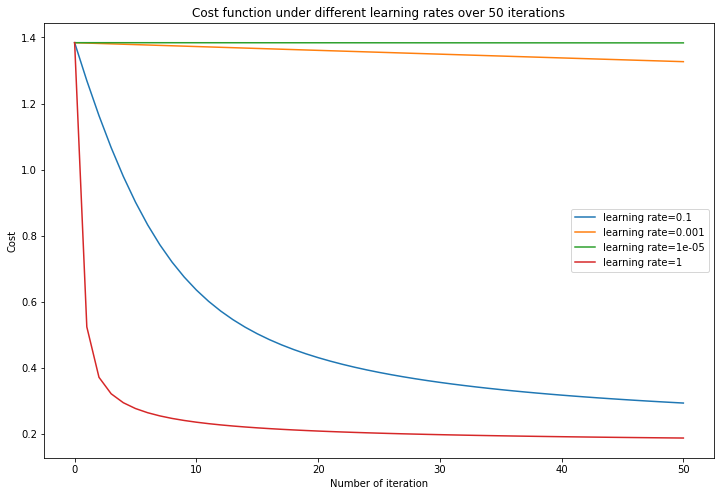

In [7]:
import numpy as np
from numpy.random import random_sample

import seaborn as sns
import matplotlib.pyplot as plt

LR = [10e-2, 10e-4, 10e-6, 1]
np.random.seed(1234)

init_w = random_sample(3)
plt.figure(figsize = (12,8))

for lr in LR:
    reg = Logistic_regression()
    reg.fit(X_train, Y_train, init_w, lr=lr, max_iter=50)
    cost = reg.learning_curve(X_train, Y_train)
    plt.plot(cost, label='learning rate={}'.format(lr))
    
# Output picture
plt.xlabel('Number of iteration')
plt.ylabel('Cost')
plt.title('Cost function under different learning rates over 50 iterations')
plt.legend()  
plt.show()


- The large learning rate can make the model's cost decrease rapidly. In contrast, the model's cost with small learning rates decreases slowly. The reason is that a large learning rate allows weights to make more changes in every step.
- Learning rate would control training speed. Usually, a larger learning rate means less training time. However, large learning rates are likely to bring the model to a local optimal value if the model's cost function is not convex. Fortunately, logistic regression's cost function is convex. Hence there is no such worry about this problem.
- I prefer the learning rate of 1 because it boosts the model's training speed without local optimal value concern.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model add a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# General  regression  model
reg = Logistic_regression()
reg.fit(X_train, Y_train, init_w, lr=1, max_iter=500)

# KNN model 
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=7)

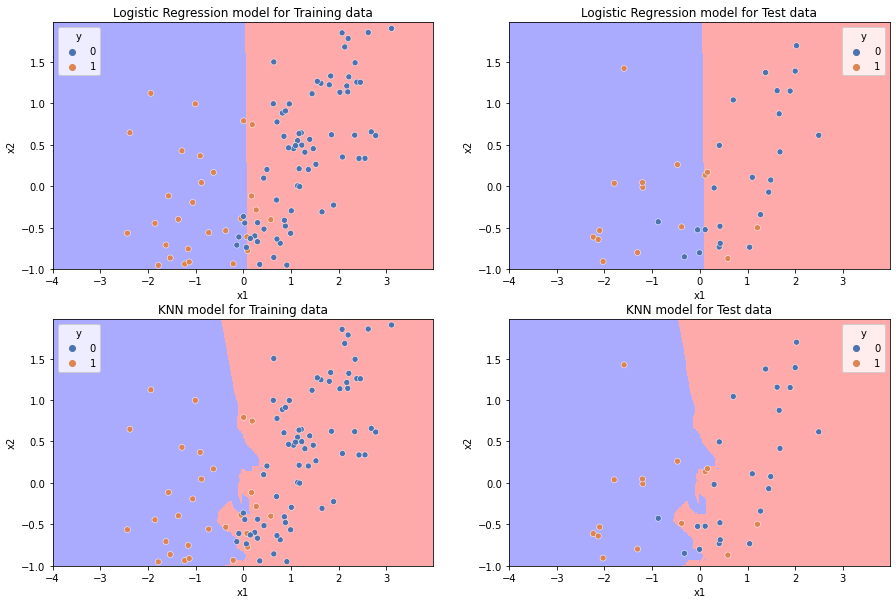

In [9]:
from matplotlib.colors import ListedColormap

step_size = .02

col_index = -1
row_index = -1

fig = plt.figure(figsize=(15,10))

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])


for model in [reg, knn]:
    col_index += 1
    row_index = -1
    
    for X,y in [(X_train, Y_train), (X_test, Y_test)]:
        row_index += 1
        
        # Plot the decision boundary.
        x_min, x_max = int(X.min().min() - 1), int(X_train.max().max() + 1)
        y_min, y_max = y.min() - 1, y.max() + 1
        
        #print("{}, {}, {}, {}".format(x_min, x_max, y_min, y_max))
        
        xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                             np.arange(y_min, y_max, step_size))
        
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        
        plt.subplot(2, 2, (2 * col_index) + row_index + 1)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
        
        # Plot also the training points
        sns.scatterplot(data=X, x="x1", y="x2", hue=y, palette="deep")
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        
        plt.title("{} model for {} data".format(
            ["Logistic Regression", "KNN"][col_index] ,
            ["Training", "Test"][row_index] ))
        

In [20]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


kf = StratifiedKFold(n_splits=10, shuffle=True)
kf_lr_pred = []
kf_knn_pred = []
kf_answer = []

for train_index, val_index in kf.split(X_train, Y_train):

    # Split data
    cv_train_X, cv_valid_X = X_train.iloc[train_index], X_train.iloc[val_index]
    cv_train_y, cv_valid_y = Y_train[train_index], Y_train[val_index]

    # Training
    reg = Logistic_regression()
    reg.fit(cv_train_X, cv_train_y, init_w, lr=1, max_iter=500)

    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, Y_train)

    # Predict
    #kf_lr_pred.extend(reg.predict(cv_valid_X))
    #kf_knn_pred.extend(knn.predict(cv_valid_X))
    
    kf_lr_pred.extend(reg.predict_proba(cv_valid_X))
    kf_knn_pred.extend(knn.predict_proba(cv_valid_X)[:, 1])
    
    kf_answer.extend(cv_valid_y)


Text(0.5, 1.0, 'ROC curve of KNN cross of 10 fold validated')

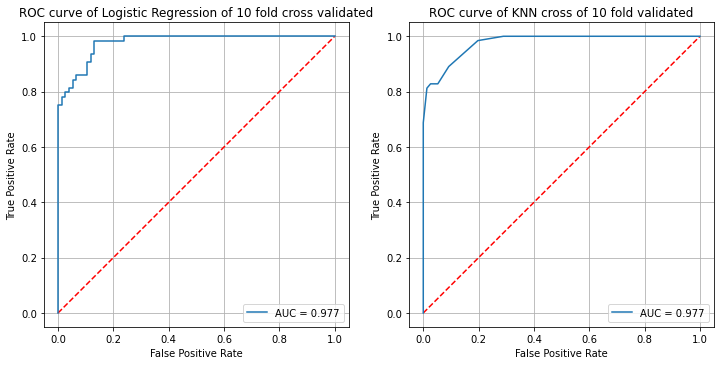

In [21]:
plt.figure(figsize=(12,8))

# Draw Logistic Regression ROC 
fpr, tpr, thres = metrics.roc_curve(kf_answer, kf_lr_pred, pos_label=1)
auc = metrics.roc_auc_score(kf_answer, kf_lr_pred)
auc_string = 'AUC = {:0.3f}'.format(auc)

plt.subplot(1, 2, 1)
plt.plot([0,1],[0,1],'--', color='red')
plt.plot(fpr, tpr, label=auc_string)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.title('ROC curve of Logistic Regression of 10 fold cross validated')

# Draw KNN ROC 
fpr, tpr, thres = metrics.roc_curve(kf_answer, kf_knn_pred, pos_label=1)
auc = metrics.roc_auc_score(kf_answer, kf_knn_pred)
auc_string = 'AUC = {:0.3f}'.format(auc)

plt.subplot(1, 2, 2)
plt.plot([0,1],[0,1],'--', color='red')
plt.plot(fpr, tpr, label=auc_string)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.title('ROC curve of KNN cross of 10 fold validated')

We can use cross-validation to help us select a better model as our final model in this problem. Before making the decision, we need a metric to allow us to evaluate all available models. AUS based on cross-validation is a powerful tool to help us achieve this goal. 

The ROC curve suggests that logistic regression is better since its AUC value is larger than KNN. That is, AUC measures the entire two-dimensional area underneath the entire ROC curve. A larger AUC typically means better performance. 

The logistic regression model's decision boundary is much smoother than the KNN model's. The KNN model's decision boundary is too rugged, which usually means the model is overfitting. 

Based on these two reasons, I would like to choose Logistics regression as my final model to predict previously unseen data for this problem.

# 2

## [30 points] Digits classification
*An exploration of regularization, imbalanced classes, ROC and PR curves*

Load your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a histogram of samples by class. What fraction of samples are positive? What issues might this cause?

**(c)** Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at 20 different values of C. As you vary the regularization coefficient, Plot 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. 
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise your results may not converge
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [28]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first time and False after the first time 
#   so that you just load the data locally instead
download_data = False

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
    
    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y!='3'] = 0
    y[y=='3'] = 1
    y = y.astype('int')
    
    # Divide the data intro a training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=88)
    
    file = open('./tmpdata', 'wb')
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open('./tmpdata', 'rb')
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

**ANSWER**

**a)**

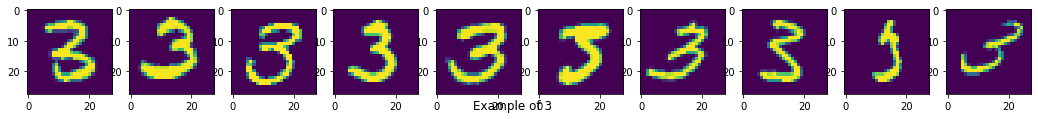

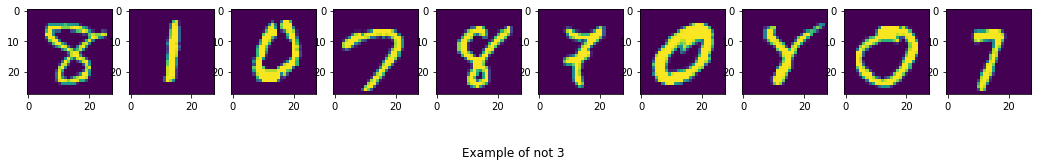

In [44]:
fig, axs = plt.subplots(1,10, figsize=(18,8))
index = 0
for ax in axs:
    image = np.reshape(X_train[y_train==1][index],[28,28])
    ax.imshow(image)
    index+=1
fig.suptitle('Example of 3')
fig.subplots_adjust(top=2)

fig, axs = plt.subplots(1,10, figsize=(18,16))
index = 0
for ax in axs:
    image = np.reshape(X_train[y_train!=1][index],[28,28])
    ax.imshow(image)
    index+=1
fig.suptitle('Example of not 3')
fig.subplots_adjust(top=2)
plt.show()

**b)**

{'Is3': 6129, 'Not3': 53871}


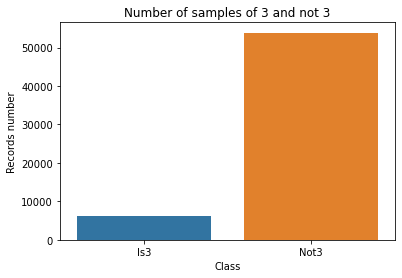

In [71]:
counter= {
    "Is3"  : sum(y_train==1),
    "Not3" : sum(y_train==0)
}
keys = list(counter.keys())
vals = [float(counter[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xlabel("Class")
plt.ylabel("Records number")
plt.title("Number of samples of 3 and not 3")

print(counter)

**Answer:** 
There are 6129 samples that belong to class 1, while there are 53871 belongs to class 0. The dataset is very unbalanced. It will lead the model to predict class 0 because it is more likely to be correct on the training data. However, it will cause the model to overfit.

**c)**

In [100]:
from sklearn.linear_model import LogisticRegression

C= np.logspace(-4, 4, 20)
coef_list = []
pred_list = []

for c in C:
    model = LogisticRegression(penalty='l1', C=1/c, solver='liblinear')
    model.fit(X_train, y_train)
    
    pred_list.append(model.predict(X_test))
    coef_list.append(model.coef_)



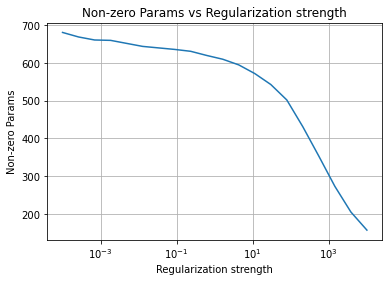

In [103]:
non_zero = [np.sum(x != 0) for x in coef_list]

sns.lineplot(y=non_zero, x=C, markers=True,  dashes=False)
plt.grid(True)
plt.xlabel('Regularization strength') 
plt.ylabel('Non-zero Params') 
plt.title('Non-zero Params vs Regularization strength') 
plt.xscale('log')

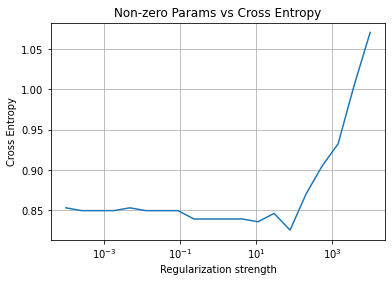

In [110]:
from sklearn.metrics import log_loss

cross_entropy = [log_loss(y_test, x) for x in pred_list] 

sns.lineplot(y=cross_entropy, x=C, markers=True,  dashes=False)
plt.grid(True)
plt.xlabel('Regularization strength') 
plt.ylabel('Cross Entropy') 
plt.title('Non-zero Params vs Cross Entropy') 
plt.xscale('log')

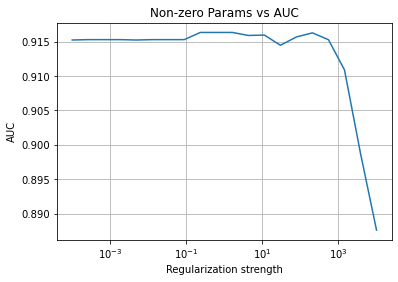

In [119]:
from sklearn.metrics import roc_curve, auc

auc_list = []

for p in pred_list:
    fpr, tpr, _ = roc_curve(y_test, p)
    auc_list.append(auc(fpr, tpr))

sns.lineplot(y=auc_list, x=C, markers=True,  dashes=False)
plt.grid(True)
plt.xlabel('Regularization strength') 
plt.ylabel('AUC') 
plt.title('Non-zero Params vs AUC') 
plt.xscale('log')

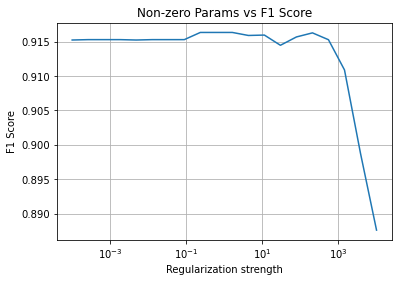

In [123]:
from sklearn.metrics import f1_score

f1 = [f1_score(y_test, p > 0.5) for p in pred_list]

sns.lineplot(y=auc_list, x=C, markers=True,  dashes=False)
plt.grid(True)
plt.xlabel('Regularization strength') 
plt.ylabel('F1 Score') 
plt.title('Non-zero Params vs F1 Score') 
plt.xscale('log')

According to the plot, cross-entropy would go down with regularization coefficient ($C$) becomes larger until it equals $10^{-2}$. Other metrics also deteriorate at the same point. Hence, $C=10^{-2}$ is the best choice. Because LogisticRegression takes $C$ for its inverse value, the turning point on the plots are at $C=10^{2}$.

**d)**

# 3

## [20 points] Comparing the Bayes' decision rule with logistic regression

The phrase "Bayes' decision rule" is often used to describe a classifier decision rule that minimizes misclassification rate (equally penalizing false positives and false negatives) for a given problem. In this exercise you will first determine the Bayes' decision rule for a binary classification problem where you know the likelihood of data from each class. 

This binary classification problem has two target classes with data distributed as exponential random variables:

$$P(x|C_i) = \lambda_i e^{-\lambda_i x}$$

Where $C_i$ represents the class from which the sample is drawn (0 or 1). This is known as the class-conditional likelihood, not surprisingly because it is the likelihood of the data conditioned on knowing what class it came from. This represents two separate density functions: one for the case when the class is 0 ($P(x|C_0)$)and one for when the class is 1 ($P(x|C_1)$). Assume that we know that $\lambda_0 = 5$ and $\lambda_1 = 5$ to fully-specify those distributions.

**(a)** Plot the probability of each class conditional distribution (e.g. likelihood function), $P(x|C_0)$ and $P(x|C_1)$ on the sample plot in the domain $x \in [0,2]$. *You can use [`scipy`'s `expon` module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) for this. Note that the `scale` parameter for this module is defined as $1/\lambda$.*

**(b)** Assuming the prior class distributions are $P(C_0)=P(C_1)=0.5$, determine the Bayes' decision rule using the information above. Remember that the Bayes Decision rule can be defined using the posterior distributions of the data; when $P(Y=1|x)>P(Y=0|x)$, predict Class 1, otherwise predict Class 0. In that way, you will assign the most probable class to the data based on the value of $x$. The decision rule will then be of the form: 

If $x > x^*$, then predict Class 0, otherwise predict Class 1

Determine the value $x^*$ that minimizes misclassification (equally penalizing false positives and false negatives, and no penalty/reward for correct detections). Show your work in deriving this value.

**(c)** How does your answer in (b) relate to the the plot you made in (a)?

**(d)** What if instead, $P(C_1)=2P(C_0)$; what would the new value of $x^*$ be in this case? Before computing the value, think through how you would expect it to change, then see if the math supports your conclusion.

**(e)** Load the test data in the file `A3_Q3_test.csv`, which follows the distributions above. Apply your Bayes decision rule to the data. What is the misclassification rate (error rate, or fraction of misclassified samples) of this decision rule? This should be the best that any algorithm could achieve (on average).

**(f)** Load the training data in the file `A3_Q3_train.csv` (which follows the distributions above) and train a logistic regression classifier on the data (using default parameters) from Scikit-Learn's `LogisticRegression` module. What is your misclassification error for your test dataset? How does this compare with the Bayes' classifier?

**(g)** What is your decision rule for the logistic regression model you just trained? To compute this, extract the parameters from your fit model (look for the `coef_` and `intercept_` attributes) and since the classes are balanced, the decision rule will be to classify a sample $x$ as Class 1 when your logistic regression sigmoid is greater than 0.5 (the halfway point from the two extremes of 0 and 1), since we assume $P(C_1|x)=\sigma(w_0 + w_1 x)$ in logistic regression. How does the decision rule from logistic regression compare with the Bayes' classifier?

**ANSWER**